In [1]:
%cd ../code

/home/chickencurry/markup-ocr/experiments/seq2seq/encoder-decoder/code


In [2]:
from data import LatexEquationDataset, LatexEquationSampler, create_tokenizer, load_tokenizer, load_img_names_from_path, curry_collate_fn, clean, get_input_token_ids, get_target_token_ids, create_img_names_to_skip, create_img_names_max_height
from model import EncoderDecoder
from eval import get_bleu, print_statistics

import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, random_split
from torchmetrics import CharErrorRate, WordErrorRate, BLEUScore
from matplotlib import pyplot as plt
from tqdm import tqdm

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cpu"

In [4]:
import torch_directml
device = torch_directml.device()

In [5]:
equations_path = "../data/formulae/math.txt"
tokenizer_path = "../data/my_tokenizer.json"

img_train_dir = "../data/formulae/train"
img_val_dir = "../data/formulae/val"
img_test_dir = "../data/formulae/test"

img_train_names_to_skip_path = "../data/img_train_names_to_skip.pkl"
img_val_names_to_skip_path = "../data/img_val_names_to_skip.pkl"
img_test_names_to_skip_path = "../data/img_names_to_skip.pkl"

train_indices_path = "../data/train_indices.pkl"

img_train_max_height_64_path = "../data/img_train_max_height_64.pkl"

In [6]:
# create_tokenizer(equations_path, tokenizer_path)
tokenizer = load_tokenizer(tokenizer_path)

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# create_img_names_to_skip(img_train_dir, img_train_names_to_skip_dir)
img_train_names_to_skip = load_img_names_from_path(img_train_names_to_skip_path)

# create_img_names_to_skip(img_val_dir, img_val_names_to_skip_dir)
img_val_names_to_skip = load_img_names_from_path(img_val_names_to_skip_path)

# create_img_names_max_height(img_train_dir, img_train_max_height_64_path)
img_train_max_height_64 = load_img_names_from_path(img_train_max_height_64_path)

In [8]:
print(img_train_max_height_64[0:10])

['0203977.png', '0012825.png', '0197669.png', '0079543.png', '0127315.png', '0069723.png', '0230119.png', '0216467.png', '0011581.png', '0029849.png']


In [9]:
train_dataset = LatexEquationDataset(equations_path, img_train_dir, tokenizer, img_train_max_height_64, img_train_names_to_skip)
val_dataset = LatexEquationDataset(equations_path, img_val_dir, tokenizer, None, img_val_names_to_skip)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=10, 
    shuffle=False, 
    # sampler=LatexEquationSampler(train_dataset, train_indices_path), 
    collate_fn=curry_collate_fn(tokenizer.convert_tokens_to_ids("[PAD]")),
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=curry_collate_fn(tokenizer.convert_tokens_to_ids("[PAD]"))
)

\theta _ { 1 } + \theta _ { 2 } = \theta _ { 3 } + \theta _ { 4 } = 9 0 ^ { \circ } .
{ \cal S } _ { \sigma } = \frac { 1 } { 4 \pi \alpha ^ { \prime } } \int _ { \Sigma } d ^ { 2 } \sigma \sqrt { \gamma } \gamma ^ { \alpha \beta } \partial _ { \alpha } X ^ { M } \partial _ { \beta } X _ { M } + \frac { 1 } { 4 \pi } \int _ { \Sigma } d ^ { 2 } \sigma \sqrt { \gamma } \Phi ( X ) R ^ { ( 2 ) } ( \sigma , \tau )
z ^ { 3 } - 2 z + 2
\Pi ^ { - 1 } = ( - 2 \kappa ) ^ { - 1 } \Pi \star p ^ { - 1 } = ( - 2 \kappa ) ^ { - 1 } \Pi p ^ { - 1 } = ( - 2 \kappa ) ^ { - 1 } p ^ { - 1 } \star \Pi
0 . 3 \mathrm { \ e V ^ { 2 } } \le \delta m ^ { 2 } = { \frac { 0 . 0 3 \mathrm { \ e V ^ { 2 } } } { ( \sin ^ { 2 } 2 \theta ) ^ { 0 . 7 } } } \le 2 . 0 \mathrm { \ e V ^ { 2 } \, . }
\mathcal { Q } = Z _ { 3 } \mathcal { Q } ^ { \mathrm { R } } , \quad \mathcal { Q } ^ { \mathrm { R } } : = { \frac { 1 } { 2 } } a _ { \mu } ^ { \mathrm { R } } ( x ) a ^ { \mu } { } ^ { \mathrm { R } } ( x ) + \alpha ^ { \

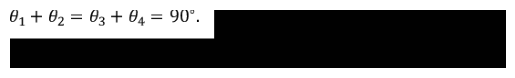

torch.Size([64, 544])


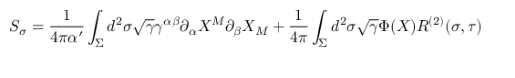

torch.Size([64, 544])


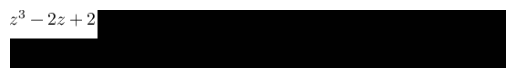

torch.Size([64, 544])


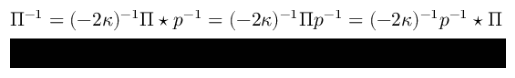

torch.Size([64, 544])


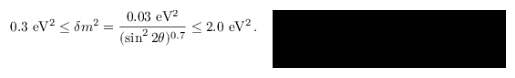

torch.Size([64, 544])


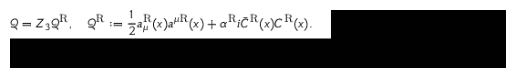

torch.Size([64, 544])


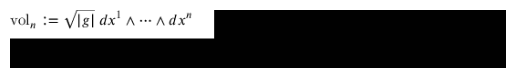

torch.Size([64, 544])


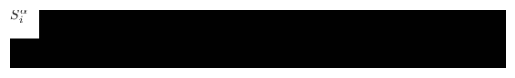

torch.Size([64, 544])


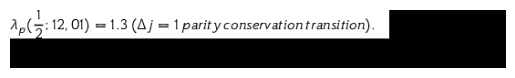

torch.Size([64, 544])


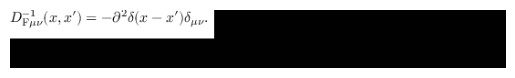

torch.Size([64, 544])


In [11]:
img_batch, token_ids_batch = next(iter(train_dataloader))
    
for token_ids in token_ids_batch:
    tokens = tokenizer.convert_ids_to_tokens(token_ids.tolist(), skip_special_tokens = True)
    print(clean("".join(tokens)))

for img in img_batch:
    plt.figure()
    plt.axis("off")
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.show()

    print(img[0].shape)

In [12]:
model = EncoderDecoder(
    vocab_size=tokenizer.vocab_size,
    d_feature=512,
    d_model=256,
    n_blocks_enc=4,
    n_blocks_dec=4,
    n_heads=8,
    d_hidden=1024,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids("[PAD]"), label_smoothing=0.1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
train_loss = []
num_epochs = 1

for epoch in range(num_epochs):
    
    model.train()
    torch.inference_mode(False)

    train_iterator = tqdm(train_dataloader, total=len(train_dataloader), desc="training epoch {}/{}".format(epoch, num_epochs))

    for img, token_ids in train_iterator:
        # move to GPU
        img = img.to(device)
        input_token_ids = get_input_token_ids(token_ids, tokenizer).to(device)
        target_token_ids = get_target_token_ids(token_ids, tokenizer).to(device)

        # forward
        logits = model(img, input_token_ids)
        loss = criterion(logits, target_token_ids)

        # collect stats
        train_loss.append(loss.item())
        train_iterator.set_postfix({"loss": f"{loss.item():.4f}"})

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
output_texts = []
target_texts = []

model.eval()
torch.inference_mode(True)

validation_iterator = tqdm(val_dataloader, total=len(val_dataloader), desc="validation epoch {}/{}".format(epoch, num_epochs))

for index, (img, token_ids) in tqdm(val_dataloader):
    # move to GPU
    img = img.to(device)
    input_token_ids = get_input_token_ids(token_ids, tokenizer).to(device)
    target_token_ids = get_target_token_ids(token_ids, tokenizer).to(device)

    # forward
    logits = model(img, input_token_ids)
    
    # collect stats
    output_texts.append(tokenizer.convert_ids_to_tokens(input_token_ids[0].tolist(), skip_special_tokens = True))
    target_texts.append(tokenizer.convert_ids_to_tokens(target_token_ids[0].tolist(), skip_special_tokens = True))

bleu = BLEUScore()(output_texts, target_texts)
wer = WordErrorRate()(output_texts, target_texts)
cer = CharErrorRate()(output_texts, target_texts)

print(f"BLEU: {bleu}")
print(f"WER: {wer}")
print(f"CRE: {cer}")